In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob 


from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

- https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?select=Training


- 각각 10,000개 이상 필요


# Project 1

- ImageDataGenrator와 TL을 이용해서 오버 피팅이 최소가 되게 정확도 90% 이상 달성.

- 만약 오버 피팅이 심하고 90% 이상의 성능이 나오지 않는다면, 문제점과 개선안을 찾아본다.

## 경로 설정

In [3]:
ROOT_DIR = 'content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')

## 데이터셋 가져오기

In [ ]:
#### Colab

from google.colab import drive

drive.mount('/content/')

shutil.copy(os.path.join('/content/My Drive/Colab Notebooks/', 'archive.zip'))

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'archive.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIRA_ROOT_DIR)

In [5]:
#### PC

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'archive.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [6]:
TRAIN_DATA_ROOT_DIR

'content\\brain_tumor\\Training'

## 정답및 전체 데이터 갯수 확인

In [24]:
print(os.listdir(TRAIN_DATA_ROOT_DIR))
print(TRAIN_DATA_ROOT_DIR)

for i in range(len(os.listdir(TRAIN_DATA_ROOT_DIR))):
    
    path = os.path.join(TRAIN_DATA_ROOT_DIR, os.listdir(TRAIN_DATA_ROOT_DIR)[i])
    print('Train ', os.listdir(TRAIN_DATA_ROOT_DIR)[i], len(os.listdir(path)))
    
print('=========' * 6)

for i in range(len(os.listdir(TEST_DATA_ROOT_DIR))):
    
    path = os.path.join(TEST_DATA_ROOT_DIR, os.listdir(TEST_DATA_ROOT_DIR)[i])
    print('Test ', os.listdir(TEST_DATA_ROOT_DIR)[i], len(os.listdir(path)))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
content\brain_tumor\Training
Train  glioma_tumor 826
Train  meningioma_tumor 822
Train  no_tumor 395
Train  pituitary_tumor 827
Test  glioma_tumor 100
Test  meningioma_tumor 115
Test  no_tumor 105
Test  pituitary_tumor 74


## Image Shape 설정

In [25]:
IMG_WIDTH = 100
IMG_HEIGHT = 100

## ImageDataGenerator를 이용하여 데이터 불러오기

In [26]:
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse')

test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse')

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [30]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


### 32 장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

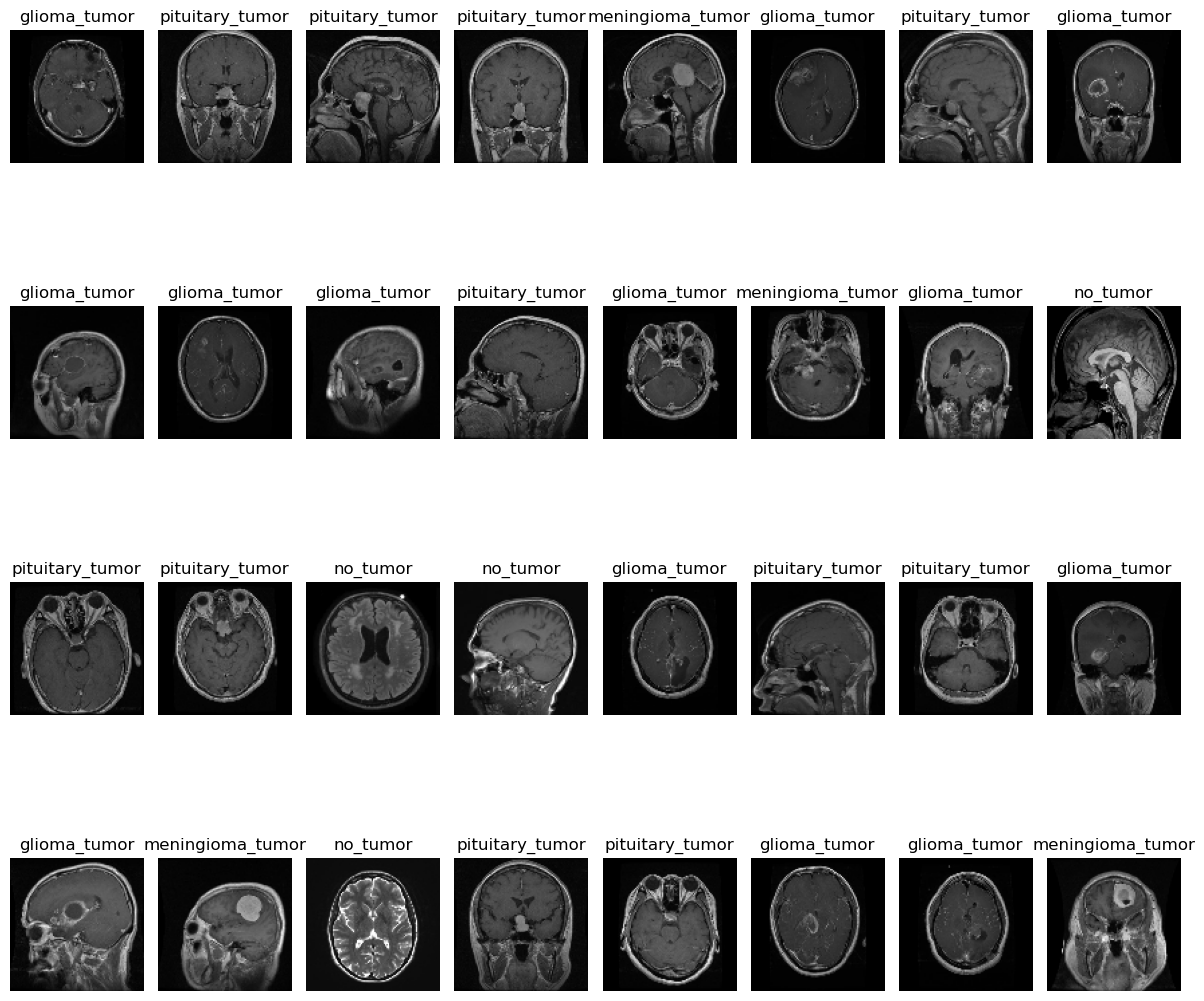

In [39]:
img, label = train_generator.next()


class_name = {0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}   
    
plt.figure(figsize=(12, 12))
for i in range(len(img)):
    plt.subplot(4, 8, i+1)
    plt.title(class_name[int(label[i])])
    plt.imshow(img[i])
    plt.axis('off')
plt.tight_layout()
    

## Fine Tuining을 위한 pre-trained 정의 및 모델 구축

In [42]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [44]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(train_generator.num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [46]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(1e-5), metrics=['acc'])

In [47]:
start_time = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=test_generator)

end_time = datetime.now()

print('Run time :', end_time - start_time)

Epoch 1/3
90/90 [==============================] - 257s 3s/step - loss: 2.3885 - acc: 0.3042 - val_loss: 1.5971 - val_acc: 0.3173
Epoch 2/3
90/90 [==============================] - 33s 361ms/step - loss: 2.0135 - acc: 0.3718 - val_loss: 1.4155 - val_acc: 0.3680
Epoch 3/3
90/90 [==============================] - 33s 367ms/step - loss: 1.7627 - acc: 0.4188 - val_loss: 1.3726 - val_acc: 0.3706
Run time : 0:05:26.189803


In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")
plt.show()


In [ ]:
model.evaluate(test_generator)

# Project-2

### Testing 디렉토리의 모든 파일을 Training 동일 디렉토리로 move

In [48]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

#############
for label_name in train_label_name_list:
    print("train label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [49]:
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_mun = 0
    for test_file in test_label_name_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1
        
    print(f'{str(move_num)} is moved into {label_name} (testing => training)')
    

FileNotFoundError: [Errno 2] No such file or directory: 'content\\brain_tumor\\Testing\\glioma_tumor\\glioma_tumor'

In [50]:
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("train label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train label :  glioma_tumor  ->  826
train label :  meningioma_tumor  ->  822
train label :  no_tumor  ->  395
train label :  pituitary_tumor  ->  827


In [51]:
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num+1
        
    print(str(move_num) +"is moved into" + label_name+\
         "(Testing => Training)")

100is moved intoglioma_tumor(Testing => Training)
115is moved intomeningioma_tumor(Testing => Training)
105is moved intono_tumor(Testing => Training)
74is moved intopituitary_tumor(Testing => Training)


## Training 전체 개수 확인

In [52]:
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("train label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train label :  glioma_tumor  ->  926
train label :  meningioma_tumor  ->  937
train label :  no_tumor  ->  396
train label :  pituitary_tumor  ->  901


## Shuffle 후 다시 Testing으로

In [54]:
#### 이동할 비율
MOVE_RATIO = .2

In [55]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    
    train_data_file_list = os.listdir(src)
    
    print('====================================')
    print('total [%s] data file nums => [%s]'%(label_name, len(train_data_file_list)))
    
    
    np.random.shuffle(train_data_file_list)
    print('train data shuffle is done.')
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print('split nums =>', split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), 
                   os.path.join(dst, test_data_file))
        
        move_num = move_num + 1
        
    print('total move num =>', move_num)
    print(('===================================='))

total [glioma_tumor] data file nums => [926]
train data shuffle is done.
split nums => 185
total move num => 185
total [meningioma_tumor] data file nums => [937]
train data shuffle is done.
split nums => 187
total move num => 187
total [no_tumor] data file nums => [396]
train data shuffle is done.
split nums => 79
total move num => 79
total [pituitary_tumor] data file nums => [901]
train data shuffle is done.
split nums => 180
total move num => 180


## Image Shape 설정

In [56]:
IMG_WIDTH = 100
IMG_HEIGHT = 100

## ImageDataGenerator를 이용하여 데이터 불러오기

In [57]:
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [58]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse')

test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse')

Found 2529 images belonging to 4 classes.
Found 631 images belonging to 4 classes.


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

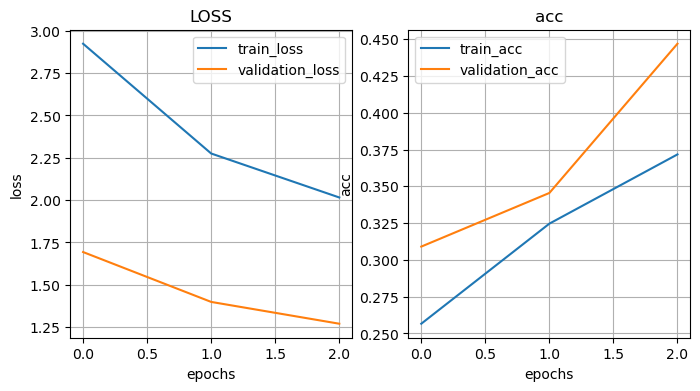

20/20 [==============================] - 2s 98ms/step - loss: 1.2702 - acc: 0.4469


[1.2702080011367798, 0.44690966606140137]

In [59]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(train_generator.num_classes, activation='softmax'))
model.summary()

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(1e-5), metrics=['acc'])

start_time = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=test_generator)

end_time = datetime.now()

print('Run time :', end_time - start_time)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")
plt.show()


model.evaluate(test_generator)

# Project-3

- Open cv이용하여 로딩, tf이용 90%넘기고 과적합 최소화

In [ ]:
train_data_list = []
train_label_list = []

image_label_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for image_label in image_label_list:
    os.path.join(TRAIN_DATA_ROOT_DIR, image_label)
    image_file_list = glob(file_peth+"/*.jpg")
    
for image_file in image_file_list:
    src_img = cv2.imread(image_file, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    
    train_data_list.append()

# Project-3

- Open cv이용하여 로딩, tf이용 90%넘기고 과적합 최소화

In [86]:
### Testing 을 training으로 이동

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)


for label_name in test_label_name_list:
    move_num = 0
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)                    

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)            # 목적지

    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))

        move_num += 1

    print(str(move_num) + "is moved into " + label_name + (" Testing => Training"))
    print("\n")
    


IMG_WIDTH = 100
IMG_HEIGHT = 100

train_data_list = []
train_label_list = []

class_dict = {"glioma_tumor":0, "meningioma_tumor":1, "no_tumor":2, "pituitary_tumor":3  }

image_label_list = os.listdir(TRAIN_DATA_ROOT_DIR)

width_list = []
height_list = []

for image_label in image_label_list:
    file_path = os.path.join(TRAIN_DATA_ROOT_DIR, image_label)
    image_file_list=glob(file_path + "/*.jpg")
    
    for image_file in image_file_list:
        src_img = cv2.imread(image_file, cv2.IMREAD_COLOR)
        
        
        width_list.append(src_img.shape[0])
        height_list.append(src_img.shape[1])
        
        src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        train_data_list.append(src_img)
        train_label_list.append(float(class_dict[image_label]))
        

    width_arr = np.array(width_list)
    height_arr = np.array(height_list)

    print('=========='*10)
    print('label = ', image_label)
    print('width average :', np.average(width_arr),
         'height average :', np.average(height_arr))
    print('width max :', np.round(np.max(width_arr)),
         'height max :', np.round(np.max(height_arr)))
    print('width min :', np.round(np.min(width_arr)),
         'height min :', np.round(np.min(height_arr)))
    print('width std :', np.round(np.std(width_arr)),
         'height std :', np.round(np.std(height_arr)))
    print('=========='*10)
    
width_arr = None
height_arr = None
width_list = None
height_list = None

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
0is moved into glioma_tumor Testing => Training


0is moved into meningioma_tumor Testing => Training


0is moved into no_tumor Testing => Training


0is moved into pituitary_tumor Testing => Training


label =  glioma_tumor
width average : 502.9719222462203 height average : 500.74190064794817
width max : 665 height max : 640
width min : 167 height min : 175
width std : 48.0 height std : 52.0
label =  meningioma_tumor
width average : 484.50080515297907 height average : 480.9151905528717
width max : 1427 height max : 1275
width min : 167 height min : 174
width std : 86.0 height std : 92.0
label =  no_tumor
width average : 461.48605577689244 height average : 457.9942452412572
width max : 1446 height max : 1375
width min : 167 height min : 174
width std : 119.0 height std : 128.0
label =  pituitary_tumor
width average : 477.2126582278481 height average : 474.89620253164554
width max : 1446 height max : 1375
width min : 16

In [76]:
X_train = np.array(train_data_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

print(X_train.shape, y_train.shape)

(3160, 100, 100, 3) (3160,)


In [77]:
#### train 데이터에서 20% 비율만큼 test 생성

MOVE_RATIO = 0.2

split_nums = int(MOVE_RATIO * len(X_train))
print("split nums : ", split_nums)

# shuffle
s = np.arange(len(X_train))
np.random.shuffle(s)

X_train = X_train[s]
y_train = y_train[s]

# test 데이터 생성
X_test = X_train[:split_nums]
y_test = y_train[:split_nums]

X_train = X_train[split_nums:]
y_train = y_train[split_nums:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

split nums :  632
(2528, 100, 100, 3) (2528,)
(632, 100, 100, 3) (632,)


## 정규화

In [78]:
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255

## 이미지 확인

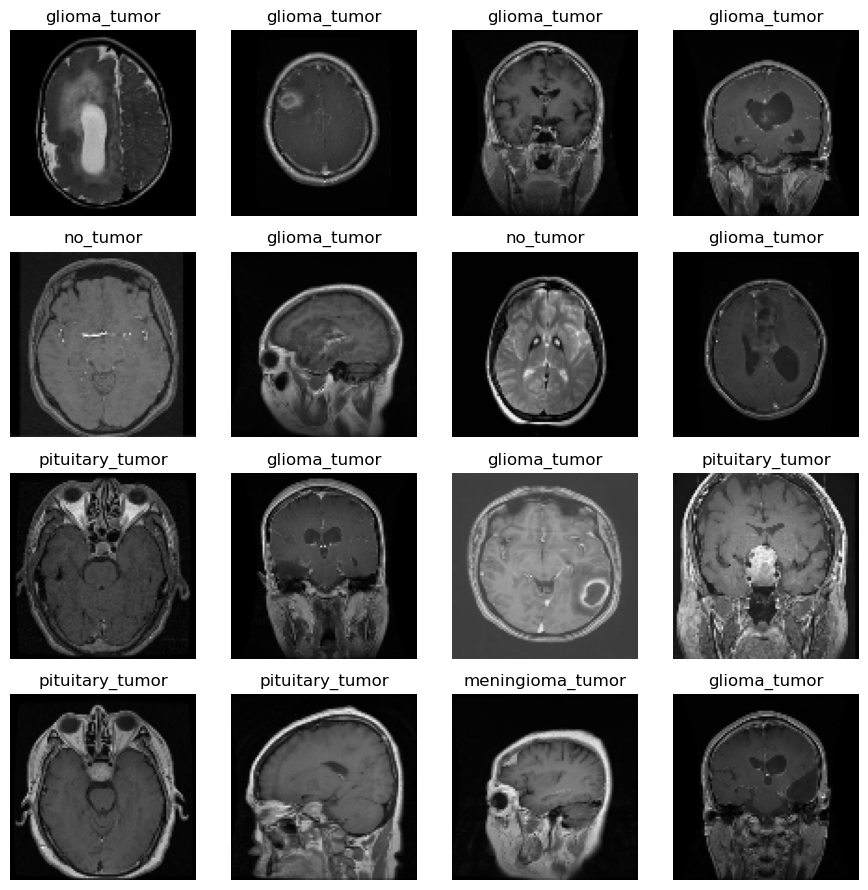

In [84]:
class_name = {0:"glioma_tumor", 1:"meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

plt.figure(figsize=(9, 9))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(class_name[int(y_train[i])])
plt.tight_layout()